In [1]:
using CSV;
using PyCall;
using PyPlot;
using Printf;
using DataFrames;

np  = pyimport("numpy");
sns = pyimport("seaborn");
ss  = pyimport("scipy.stats");
wrg = pyimport("warnings");
pd  = pyimport("pandas");

In [200]:
ps = pyimport("pyspark.pandas");
pd = pyimport("databricks.koalas");
tree = pyimport("sklearn.tree");
layers = pyimport("keras.layers");
models = pyimport("keras.models");
prepro = pyimport("sklearn.preprocessing");
utils  = pyimport("sklearn.utils");
metrics = pyimport("sklearn.metrics");
model_selection = pyimport("sklearn.model_selection");

In [9]:
wrg.filterwarnings("ignore")

# 1.0. Capítulo 1

## 1.1. Correlação

### 1.1.1. R de Pearson

O coeficiente de correlação de pearson é muitas vezes o primeiro coeficiente estudado ou abordado em livros.<br>
São ditos os dados que são positivamente correlacionados quando os valores de **x** acompanham os valores de **y** e negativamente correlacionados se os valores altos de **x** acompanharem os valores baixos de **y**.<br>**Causalidade** a variável **x** é a causa da variável **y**, logo por exemplo a correlação entre número de vendas e clientes é positiva, mas não quer dizer que quantos mais clientes existem mais vendas eu tenha.<br>Ex: O número de consumo de **margarina** e o número de **divórcios** em Maine.

Fórmula do coeficiente de pearson.

$$r = \frac{n(\sum{xy}) - (\sum{x})(\sum{y}))}{\sqrt{(n\sum{(x^2)}-(\sum{x})^2)~(n\sum{(y^2)}-(\sum{y})^2)}}$$

In [4]:
function plot_linear(a, b, d, r1, r2)
    fig, ax = plt.subplots( figsize=(6, 5) );

    x = np.arange( r1, r2, 1 )
    y = a * x .+ b + np.random.normal( 0, d, length(x) );
    
    r = (length(x)sum(x .* y) - (sum(x)sum(y))) / (sqrt((length(x)sum(x.^2) - (sum(x))^2) * (length(y)sum(y.^2) - (sum(y))^2)))
    
    ax = sns.regplot(x, y, color="r")
    if r >= 0
        ax.set_title(("Correlação Positiva: " * string(round(r, digits=4))))
    else
        ax.set_title(("Correlação Negativa: " * string(round(r, digits=4))))
    end
end;

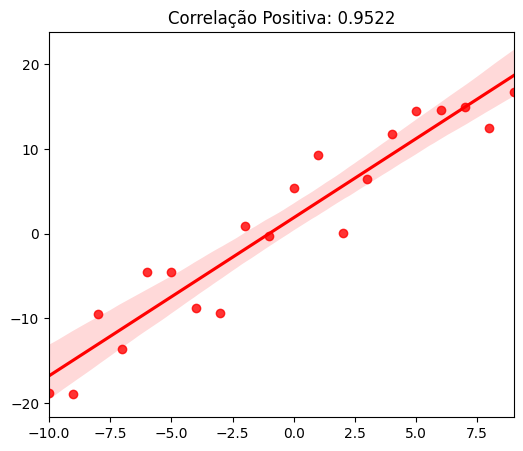

In [7]:
plot_linear(2, 2, 3, -10, 10);

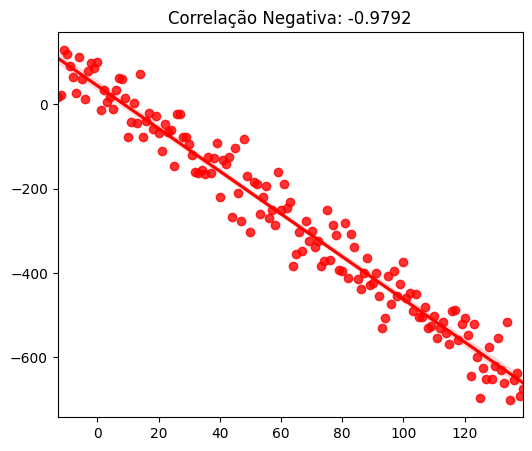

In [8]:
plot_linear(-5, 40, 50, -13, 140);

### 1.1.2. Rho de spearman

Robusto contra outliers e calculado em relação ao ranqueamento ou ordens dos dados, também mede relações lineares e não lineares.

$$r_s = 1 - \frac{6\sum{d^2}}{n^3 - n}$$

In [95]:
function spearman_plot( size, power )
    log_a = [log1p(abs(j-10)) for j in 1:size]
    log_b = [log1p(j)^power for j in 1:size]
    cor, _ = ss.spearmanr( log_a, log_b );

    fig, ax = plt.subplots( figsize=(5, 5) )
    ax.plot( log_a, color="b", linestyle="--", label="Log - 6" )
    ax.plot( log_b, color="r", linestyle="--", label="Negative Log" )
    ax.set_title( "Correlação: " * string(round(cor, digits=4)) )
    plt.legend(); 
end;

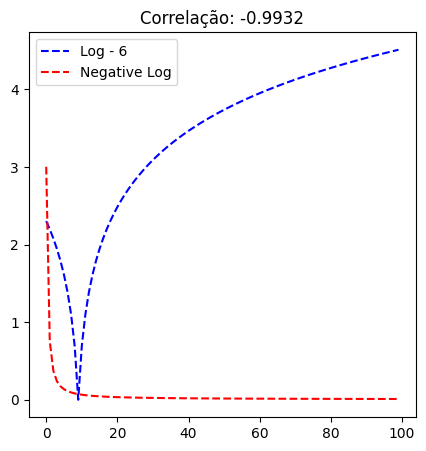

In [96]:
spearman_plot( 100, -3 );

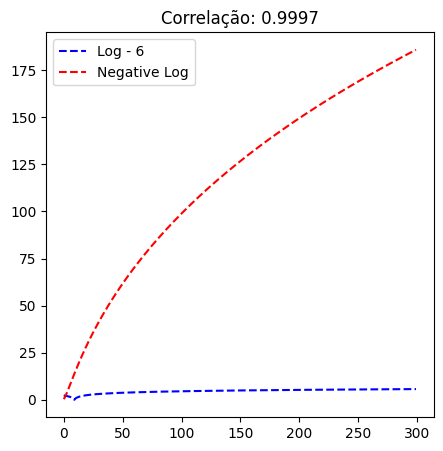

In [97]:
spearman_plot( 300, 3 );

### 1.1.4. V de Cramér

O V de cramér basicamente serve para calcular a correlação entre variaveis categoricas.

Existe a versão corrigida da fórmula de cramér que esta abaixo, k e r são as dimensões da matriz.

$$V = \sqrt{\frac{\varphi^{2}~ou~X^2 / n}{min(k-1, r-1)}}$$

$$\varphi^2 = max(0, \varphi^2 - \frac{(k-1) - (r-1)}{n-1}$$

$$cor~k = k - \frac{(k-1)^2}{n-1}$$

$$cor~r = r - \frac{(r-1)^2}{n-1}$$

In [3]:
function cramer_v( x, y )
    x = np.array( x )
    y = np.array( y )
    
    cm = pd.crosstab( x, y ).values
    n  = sum(cm)
    r, k = size(cm)
    
    chi2 = ss.chi2_contingency( cm )[1]
    chi2corr = max( 0, chi2 - ((( k-1 ) * ( r-1 )) / ( n-1 ) ))
    
    kcorr = k - ((( k-1 )^2) / ( n-1 ))
    rcorr = r - ((( r-1 )^2) / ( n-1 ))

    return np.sqrt( ( chi2corr / n ) / ( min( kcorr - 1, rcorr - 1 ) ) )
end;

df = DataFrame(CSV.File("data/store.csv"))
df = hcat(df[:, 2:3], df.StoreType )
df = rename(df, Dict("x1" => "State"));

# Rename Rows
df.Assortment = [replace(i, "a" => "BASIC") for i in df.Assortment];
df.Assortment = [replace(i, "b" => "EXTRA") for i in df.Assortment];
df.Assortment = [replace(i, "c" => "EXTENDED") for i in df.Assortment];

# Generate FataFrame
results = []
data = DataFrame()

for i in ["StoreType", "Assortment", "State"] 
    a = cramer_v( Array(df.StoreType), Array(df[:, i]) )
    b = cramer_v( Array(df.Assortment), Array(df[:, i]) )
    c = cramer_v( Array(df.State), Array(df[:, i]) )
    
    corr = Dict(i => [a, b, c])
    append!(results, corr)
end

df2 = DataFrame( results ) # Plotar um Mapa de Calor / Heatmap

,StoreType,Assortment,State
,Float64,Float64,Float64
1,1.00135,0.54068,1.00135
2,0.54068,1.0009,0.54068
3,1.00135,0.54068,1.00135


## 1.2. Dois Gráficos de Densidade

Hexagonal Binning relaciona as duas variaveis aleatorias normais em hexágonos, mesma coisa que o Histograma.<br>Kernel Density Estimate, Análogo análogo ao Hexagonal, porem em densidades com curvas. 

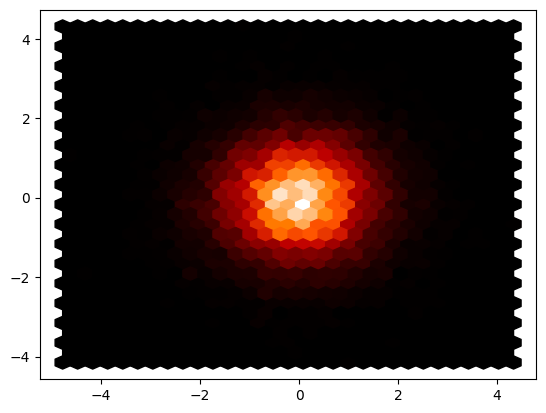

In [205]:
plt.hexbin( np.random.randn(20000), np.random.randn(20000), gridsize=30, cmap="gist_heat" );

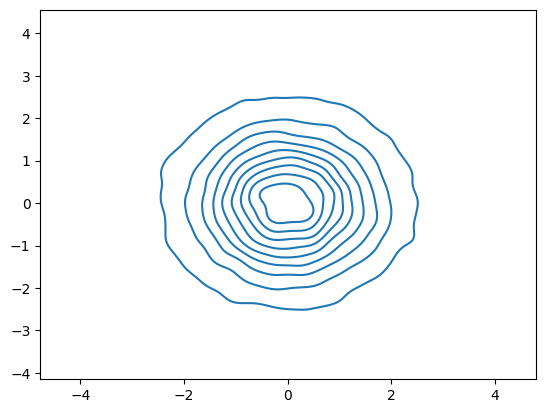

In [207]:
sns.kdeplot(np.random.randn(20000), np.random.randn(20000) );

# 2.0. Capítulo 2

## 2.1. Distribuição de Amostragem de uma Estatística

A distribuição de uma estatística amostral como a média costuma ser mais regular e campanular do que a distribuição dos proprios dados quanto maior a amostra em que a estatística se baseia. Além disso, quanto maior a amostra, mais estreita é a distribuição da estatística amostral. "Tende a Normal"...    

In [15]:
df = pd.read_csv("data/loans_income.csv");

In [16]:
sample = df.sample(1000)

sample_of_5 = pd.DataFrame( Dict("income" => [df["x"].sample(5).mean() for _ in 1:1000],
                                 "type" => "mean_of_5") )

sample_of_10 = pd.DataFrame( Dict("income" => [df["x"].sample(10).mean() for _ in 1:1000],
                                  "type" => "mean_of_10") )

sample_of_20 = pd.DataFrame( Dict("income" => [df["x"].sample(20).mean() for _ in 1:1000],
                                  "type" => "mean_of_20") )

result = pd.concat([sample, sample_of_5, sample_of_10, sample_of_20]);

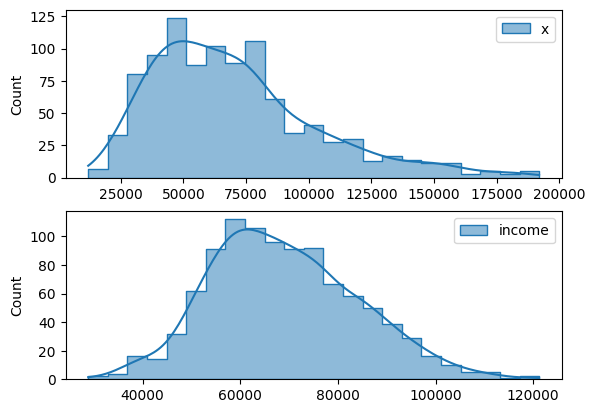

In [21]:
PyPlot.subplot(2, 1, 1);
sns.histplot( sample, kde=true, element="step" );

PyPlot.subplot(2, 1, 2);
sns.histplot( sample_of_5, kde=true, element="step" );

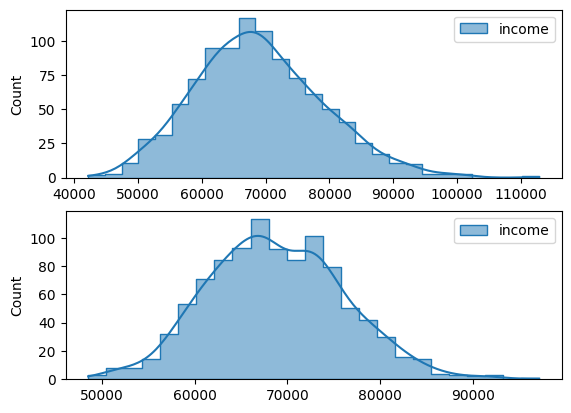

In [20]:
PyPlot.subplot(2, 1, 1);
sns.histplot( sample_of_10, kde=true, element="step" );

PyPlot.subplot(2, 1, 2);
sns.histplot( sample_of_20, kde=true, element="step" );

## 2.2. O Bootstrap

O bootstrap é uma forma eficiente e eficaz de estimar a distribuição amostral de uma estatística ou de parâmetros de modelo.<br>Conceitualmente pode-se imaginar o Bootstrap como uma replicação da amostra original várias vezes de modo a ter uma população hipotética que representa todo o conhecimento da amostra original só que maior.<br>Logo amostramos com reposição, dessa forma cria-se efetivamente uma população infinita na qual a probabilidade de um elemento ser extraído continua a mesma de extração por extração.<br>Com os resultados é possível encontrar um intervalo de confiança.

### 2.2.1. Sem Bootstrap

In [24]:
# Load and Prepare Dataset
df = DataFrame(CSV.File("data/diabetes.csv"));

x = df[:, 1:8];
x = hcat(x[:, 1], x[:, 2], x[:, 3], x[:, 4], x[:, 5], x[:, 6], x[:, 7]);

y = df[:, 9];

# Transform Variables
mms = prepro.MinMaxScaler()
x = mms.fit_transform( x );

# Split Dataset
x_train, x_test, y_train, y_test = model_selection.train_test_split( x, y, train_size=0.9 );

In [21]:
# Simple Logistic Regression
model = models.Sequential()
model.add( layers.Dense( 1, activation="sigmoid") )
model.compile( optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"])

In [22]:
history = model.fit( x_train, y_train, epochs=2000, verbose=0 );
test = model.evaluate( x_test, y_test );

3/3 [==============================] - 0s 2ms/step - loss: 0.5010 - accuracy: 0.7143


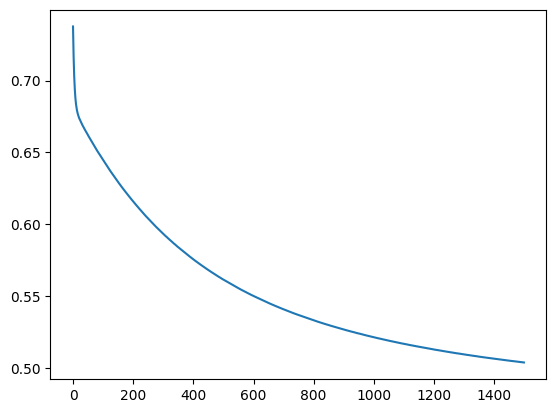

In [117]:
PyPlot.plot( history.history["loss"] );

####  Conclusão

In [116]:
@printf "Accuracy %.2f%%" maximum(history.history["accuracy"])*100

Accuracy if 77.71%

### 2.2.1. Com Bootstrap

In [25]:
# Configuration of Bootstrap
n_inter = 1000
n_size  = trunc(Int, (768 * 0.5))
stats   = []

# Set Up Data
df = hcat(df[:, 1], df[:, 2], df[:, 3], df[:, 4], df[:, 5], df[:, 6], df[:, 7], df[:, 8], df[:, 9])

for i in 1:n_inter
    sample = utils.resample( df, n_samples=n_size );
    y = sample[:, 9];
    x = sample[:, 1:8];

    x = mms.fit_transform( x );

    # Split Dataset
    x_train, x_test, y_train, y_test = model_selection.train_test_split( x, y, train_size=0.9 );

    model = tree.DecisionTreeClassifier() # Decision Tree, dont NN.
    model.fit( x_train, y_train )
    
    prediction = model.predict( x_test )
    score = metrics.accuracy_score( y_test, prediction )
    
    append!(stats, score)
end

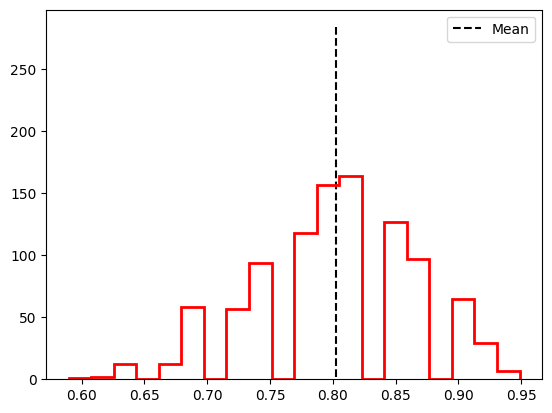

In [106]:
plt.hist( stats, color="r", linewidth=2, histtype="step", bins=20 );
plt.vlines( np.mean( stats ), ymin=n_size-100, ymax=1., color="k", linestyle="--", label="Mean" );
plt.legend();

#### Conclusão

In [110]:
α = 0.95

p = ((1.0 - α)/2.0)*100
lower = np.percentile(stats, p)*100

p = (α + (1.0 - α)/2.0) *100
max = np.percentile(stats, p)*100

@printf "%.0f%% Confidence Intervals %.2f%% and %.2f%%" α*100 lower max

95% Confidence Intervals 66.67% and 92.31%

## 2.3. Distribuições

### 2.3.1 Distribuição Binomial

A distribuição Binomial é, vamos dizer assim uma continuação da distribuição de Bernoulli, onde a distribuição de Bernoulli trabalha somente com duas possibilidades, ou 1 geralmente chamado de evento de sucesso ou 0 de fracasso contendo as probabilidades desses eventos ao lado.

In [17]:
bernoulli = pd.DataFrame([["Azul", 0.35], ["Vermelho", 0.65]]);
bernoulli.columns = ["X", "Probabilidade"];
bernoulli

,X,Probabilidade
0,Azul,0.35
1,Vermelho,0.65


Formula da Distribuição Binomial

$$ P(r/n,p) = {{n}\choose{r}} \cdot p^r \cdot (1-p)^{n-r}, onde {{n}\choose{r}} = C_{nk} = \frac{n!}{r! \cdot (n - r)!}$$

 - r: Eventos de Interesse.
 - n: Repetições.
 - p: Probabilidade do Evento.

In [16]:
P(r, n, p) = (factorial(n) / (factorial(r) * factorial(n-r))) * (p^r) * ((1 - p)^(n-r));

Qual é a probabilidade de sair 3 caras em 4 jogadas e a probabilidade de cada cara é $\frac{1}{2}$ 

$$ P(2 / 4,\frac{1}{2}) = 6 \cdot (\frac{1}{2})^2 \cdot (\frac{1}{2})^2 = \frac{6}{16}$$

In [18]:
@printf "A probabilidade de sair três caras em quatro jogadas é: %.3f%% " P(2, 4, .5)*100

A probabilidade de sair três caras em quatro jogadas é: 37.500% 

Qual é a chance de 3 pessoas que eu ligar das 10 entrarem em churn sabendo que a probabilidade de uma pessoa em churn na base de dados é 0.15%? 

In [19]:
@printf "A probabilidade de 3 das 10 pessoas ligadas entrarem em churn é: %.3f%%" P(3, 10, .15)*100

A probabilidade de 3 das 10 pessoas ligadas entrarem em churn é: 12.983%

Confome a probabilidade tende a o equilibrio, ou seja, .5% de cair cara ou coroa, logo a distribuição parece uma Normal.

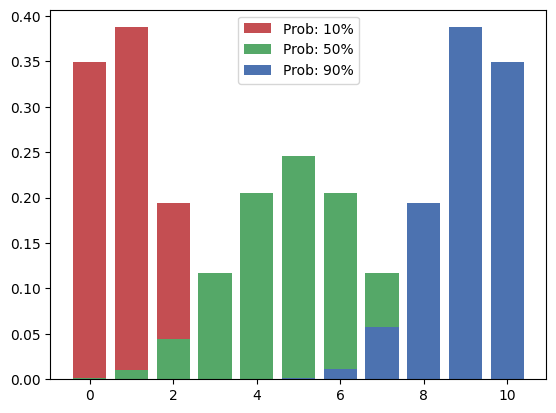

In [1012]:
prob  = [0.1, 0.5, 0.9]
color = ["r", "g", "b"]
label = ["Prob: 10%", "Prob: 50%", "Prob: 90%"]

for i in 1:3
    res = [ss.binom.pmf(r, 10, prob[i]) for r in 0:10]
    plt.bar(r_values, res, color=color[i], label=label[i]);
    plt.legend()
end

### 2.3.2 Distribuição de Poisson

Alta concentração de eventos próximos ao eixo y, uma das principais características é que não tem repetições como na distribuição binomial trabalha em um intervalo continuo.<br>Ex: Em um estudo de chuva ou cliques em um site, no exemplo da chuva, qual é a chance de uma chuva, só que não existe o evento "não chuva" entre duas chuvas.

Imagine um intervalo, que começa e 0 até uma variável W por exemplo. E eu divido em **n** intervalos muito pequenos, onde n tende ao infinito., logo a probabilidade está tendendo a 0 pois existem n intervalinhos, com essa quantidade de intervalos, virou uma binomial, ou seja, choveu ou não por exemplo.

$$P(r/\frac{\lambda}{r}, n) = \lim_{n\to\infty} (\frac{\lambda}{n})^r . (1-\frac{\lambda}{n})^{n-r}. \frac{n!}{r!(n-r)!}$$

Distribuição de Poisson, logo $\lambda$ (Quantidade de Chuva) = p * n, então p = $\frac{\lambda}{n}$. No Limite que n tende ao infinito, o produto de **n** e **r** não vai mudar pois **r** sempre vai ficar menor e **n** sempre vai ficando maior.

$$P(r/\lambda)= \frac{e^{-\lambda} \cdot \lambda^{r} }{r!}$$

In [11]:
P(λ, r) = np.e^-λ * λ^r / np.math.factorial(r);

Dado que eu esperava em média 35 carros entrando no shopping, qual a probabilidade de aparecer 20?

In [15]:
@printf "A probabilidade de somente uma chuva no mês é de: %.3f%%" P(35, 20)*100

A probabilidade de somente uma chuva no mês é de: -0.000%

In [140]:
# Julia tem problema com elevar x a o espoente y
function f(x, y)
    [x*=x for _ in 1:y]
end
f(35, 20)

20-element Vector{Int64}:
                 1225
              1500625
        2251875390625
  6616016035436858689
  7865930784382691969
 -4822766768660441855
 -1652024524321314303
   450275795304469505
 -6392656039275616255
  7551947002216534017
  3654036140188672001
  8358544585278177281
  4785494631104806913
 -2679742982427181055
  2893676706708193281
  8010019347241369601
   -48246705104617471
 -5786811055723249663
 -8394158839848501247
   541221425122377729

Logo em Python, aplicando a mesma função irá retornar a probabilidade de 0.0019

In [14]:
@printf "A probabilidade de somente uma chuva no mês é de: %.3f%%" P(5, 1)*100

A probabilidade de somente uma chuva no mês é de: 3.369%

In [895]:
x = ss.poisson.rvs(2, size=500);

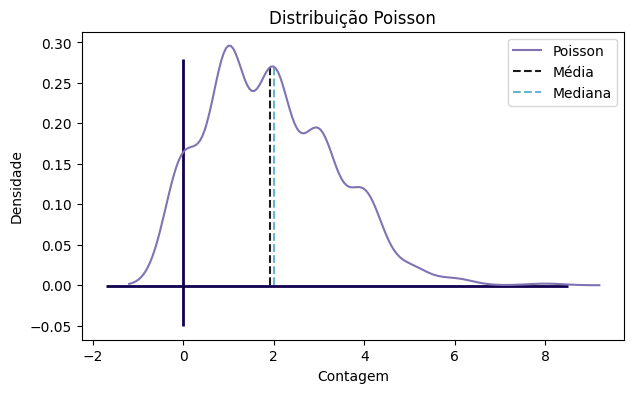

In [896]:
fig, ax = plt.subplots( figsize=(7, 4) )
ax = sns.distplot(x, color="m", hist=false, label="Poisson");
ax.vlines( np.mean(x), 0, 0.27, color="k", linestyle="--", label="Média" )
ax.vlines( np.median(x), 0, 0.27, color="c", linestyle="--", label="Mediana" )
ax.vlines( 0, -0.05, 0.28, color="#12004f", linewidth=2, linestyle="-")
ax.hlines( -0.001, -1.7, 8.5, color="#12004f", linewidth=2, linestyle="-")
ax.set_xlabel("Contagem");
ax.set_ylabel("Densidade");
ax.set_title("Distribuição Poisson")
ax.legend();

### 2.3.5 Distribuição Normal

A distribuição Normal e simétrica a média e as outras distribuições são geralmente moldadas de forma normal. Em uma distribuição normal 68% dos dados ficam dentro de um desvio-padrão da média e 90% dos dados em dois desvios-padrões.<br>A diferença entre a distribuição normal das outras distribuições (binomial e poisson) é que na noção de distribuição discreta e continua, ambas são distribuições discretas pois as possibilidades dos eventos eram discretos, agora x pode assumir uma probabilidade, logo a função é chamada de densidade de probabilidade.<br>Onde para calcular a área em baixo da curva usa-se a ferramenta de Integral. ($\int_{0}^{1}f(x) \,dx$)

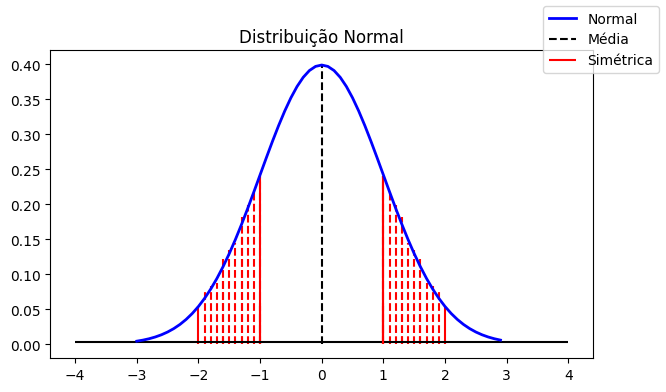

In [97]:
range = np.arange(-3, 3, 0.1)
fig, ax = plt.subplots( figsize=(7, 4) )
ax.plot(range, ss.norm.pdf(range), color="b", linewidth=2, label="Normal");
[ax.vlines(  i, 0, 0.24, color="r") for i in -1:1 if i != 0]
[ax.vlines(  i, 0, 0.055, color="r") for i in -2:2 if i != 0]
[ax.vlines(  i, 0, (0.50/(i*2.0)-.01), color="r", linestyle="--" ) for i in 1:.1:1.3];
[ax.vlines(  i, 0, (0.50/(i*2.3)-.01), color="r", linestyle="--" ) for i in 1.3:.1:1.6];
[ax.vlines(  i, 0, (0.50/(i*3)-.01), color="r", linestyle="--" )   for i in 1.6:.1:1.9];
[ax.vlines( -i, 0, (0.50/(i*2.0)-.01), color="r", linestyle="--" ) for i in 1:.1:1.3];
[ax.vlines( -i, 0, (0.50/(i*2.3)-.01), color="r", linestyle="--" ) for i in 1.3:.1:1.6];
[ax.vlines( -i, 0, (0.50/(i*3)-.01), color="r", linestyle="--" )   for i in 1.6:.1:1.9];
ax.hlines( .003, -4, 4, color="k")
ax.vlines( 0, 0, 0.4, color="k", linestyle="--", label="Média")
ax.vlines( 1, 0, 0.24, color="r", label="Simétrica")
ax.set_title("Distribuição Normal")
fig.legend();

Função densidade de probabilidade

$$f(x) = \frac{1}{\sqrt{2 \pi}\sigma} \cdot e^{\frac{-(x-\bar{x})^2}{2 \sigma^2}}$$

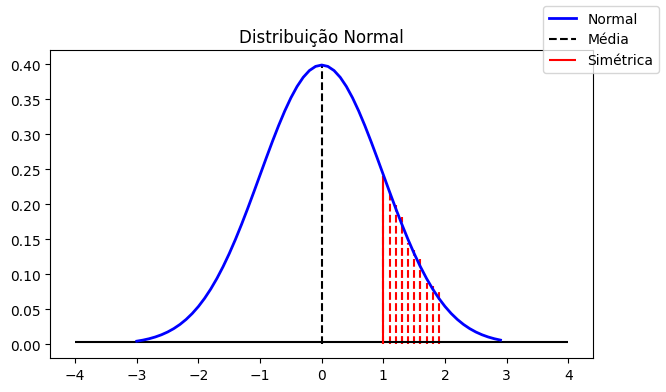

In [94]:
range = np.arange(-3, 3, 0.1)
fig, ax = plt.subplots( figsize=(7, 4) )
ax.plot(range, ss.norm.pdf(range), color="b", linewidth=2, label="Normal");
[ax.vlines(  i, 0, (0.50/(i*2.0)-.01), color="r", linestyle="--" ) for i in 1:.1:1.3];
[ax.vlines(  i, 0, (0.50/(i*2.3)-.01), color="r", linestyle="--" ) for i in 1.3:.1:1.6];
[ax.vlines(  i, 0, (0.50/(i*3)-.01), color="r", linestyle="--" )   for i in 1.6:.1:1.9];
ax.hlines( .003, -4, 4, color="k")
ax.vlines( 0, 0, 0.4, color="k", linestyle="--", label="Média")
ax.vlines( 1, 0, 0.24, color="r", label="Simétrica")
ax.set_title("Distribuição Normal")
fig.legend();

Como a variável x é continua, sendo assim pode assumir infinitos valores, e tambem toda a area da curva gaussiana é 1.<br>
Logo para calcular a área entre 1 e 2 da normal:

$$P = \int_{1}^{2}\frac{1}{\sqrt{2\pi}\sigma} \cdot e^{\frac{-(x-\bar{x})^2}{2 \sigma^2}}\,dx$$

### 2.3.6. QQ Plot

In [ ]:
##

### 2.3.3 Distribuição Exponencial

A concentração dos dados em uma distribuição exponencial é diferente.

In [870]:
x = ss.expon.rvs( 0.2, size=1000);

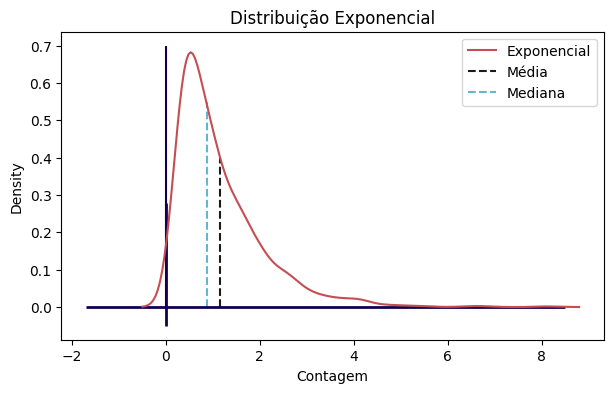

In [871]:
fig, ax = plt.subplots( figsize=(7, 4) )
ax = sns.distplot(x, color="r", hist=false, label="Exponencial");
ax.set_xlabel("Contagem");
ax.vlines( np.mean(x), 0, 0.4, color="k", linestyle="--", label="Média" )
ax.vlines( np.median(x), 0, 0.55, color="c", linestyle="--", label="Mediana" )
ax.vlines( 0, 0, 0.7, color="#12004f", linestyle="-")
ax.vlines( 0, -0.05, 0.28, color="#12004f", linewidth=2, linestyle="-")
ax.hlines( -0.001, -1.7, 8.5, color="#12004f", linewidth=2, linestyle="-")
ax.set_title("Distribuição Exponencial")
ax.legend();

### 2.3.4 Distribuição Weibull

In [12]:
# Melhorar Informações

É uma extensão da distribuição Exponencial, na qual a taxa de evento pode mudar de acordo ocm um "parâmetro de forma" β<br>
Se β > 1, a probabilidade de um evento aumenta com o tempo.<br>
Se β < 1, a probabilidade de um evento diminui com o tempo.<br>
Sendo assim, pode ser utilizada na análise de sobrevivência & confiabilidade, e sua função é:

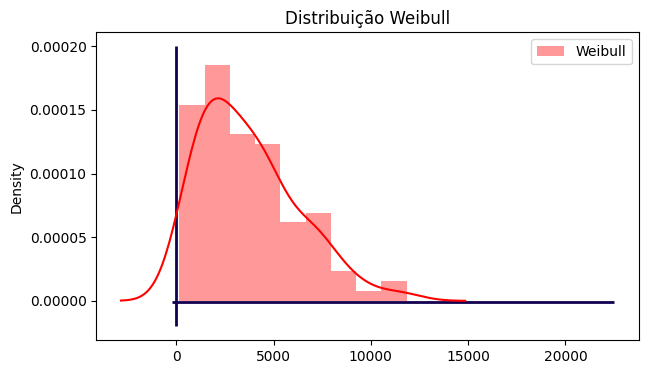

In [86]:
x = ss.weibull_min.rvs(1.5, scale=5000, size=100)

fig, ax = plt.subplots( figsize=(7, 4) )
ax = sns.distplot( x, color="r", label="Weibull");
ax.hlines( -.1/(1000*100), 150*150, -200, color="#12004f", linewidth=2, linestyle="-")
ax.vlines( -.1/(1000*100), -.1/(500*10), .1/(500), color="#12004f", linewidth=2, linestyle="-")
ax.set_title("Distribuição Weibull")
ax.legend();

# 3.0. Capítulo 3

## 3.1. Teste T de Student

O teste T de Student nada mais é que um teste de comparação de dois grupos em relação a sua média.<br>Nas quais os dados são numéricos, mas para que seja utilizado é necessário usar uma forma padronizada de estatística de teste.

$$H_o: \text{A média do tempo de sessão para a página A é maior ou igual que a B}$$
$$H_a: \text{A média do tempo de sessão para a página A é menor que a B}$$

In [75]:
df = DataFrame(CSV.File("data/web_page_data.csv"));

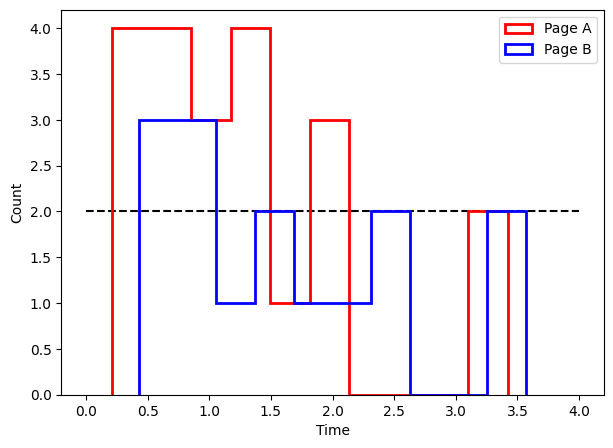

In [20]:
fig, ax = plt.subplots( figsize=(7, 5) )
ax.hist( df[df.Page .== "Page A", 2], histtype="step", linewidth=2, color="r", label="Page A")
ax.hist( df[df.Page .== "Page B", 2], histtype="step", linewidth=2, color="b", label="Page B")
ax.hlines( y=2.0, xmin=-0, xmax=4., linestyle="--", color="k" )
ax.set_xlabel("Time")
ax.set_ylabel("Count")
ax.legend();

In [179]:
list = ["less", "two-sided"]
mean_a = np.mean( df[df.Page .== "Page A", 2] )
mean_b = np.mean( df[df.Page .== "Page B", 2] )
std_a = np.std( df[df.Page .== "Page A", 2] )
std_b = np.std( df[df.Page .== "Page B", 2] )
n1 = length(df[df.Page .== "Page A", 2])
n2 = length(df[df.Page .== "Page B", 2])

for i in list
    t_test = ss.ttest_ind( df[df.Page .== "Page A", 2], df[df.Page .== "Page B", 2], equal_var=false, alternative=i )
    if i == "less"
        @printf "P-Value One Sided %.3f\n" t_test[2]
        @printf "T-Statistic: %.3f\n" t_test[1]
    else
        @printf "\nP-Value Two Sided %.3f\n" t_test[2]
        @printf "T-Statistic: %.3f\n" t_test[1]
    end
end

P-Value One Sided 0.141
T-Statistic: -1.098

P-Value Two Sided 0.282
T-Statistic: -1.098


In [189]:
pearson_r(ti, df) = √( (ti^2) / (ti^2 + df ) );
glass_delt( x_bari, x_barj, stdi ) = (x_bari - x_barj) / stdi;
cohen_d(x_bari, x_barj, stdi, stdj) = ( x_bari - x_barj ) / √( ( stdi^2 + stdj^2 ) / 2 );
hedge_g( d, ni, nj ) = ( d * ( 1 - ( 3 / (4*(ni + nj - 9)))));

gl = glass_delt( mean_a, mean_b, std_a )
r  = pearson_r( t_test[1], 34 )
d  = cohen_d( mean_a, mean_b, std_a, std_b )
g  = hedge_g( d, n1, n2 )

@printf "Glass ◭: %.4f" gl
@printf "\nPearson ρ: %.4f" r
@printf "\nCohen's d: %.4f" d
@printf "\nHedge's g: %.4f" g

Glass ◭: -0.4131
Pearson ρ: 0.1851
Cohen's d: -0.3869
Hedge's g: -0.3761

 - Glass ◭: É a diferença média entre os dois grupos dividido pelo desvio padrão do grupo controle.
 - Pearson ρ: Pearson / Rosenthal serve para calcular a correlação utilizando o P Value e os Graus de Liberdade.
 - Cohen's d: Diferença das médias, é uma formula do "tamanho do efeito", que resumidamente mede o tamanho das associações entre as variáveis ou da diferença entre as médias dos grupos.
 - Hedge's g: Correção do D de Cohen.

# Capítulo 4

# x.0. Referências

PETER BRUCE & ANDREW BRUCE **Estatística prática para cientistas de dados: 50 conceitos essenciais**.
<br>Link: https://www.amazon.com.br/Estat%C3%ADstica-Pr%C3%A1tica-Para-Cientistas-Dados/dp/855080603X<br><br>
DAVID MATOS **8 Conceitos Estatísticos Fundamentais Para Data Science**. <br>Link: https://www.cienciaedados.com/8-conceitos-estatisticos-fundamentais-para-data-science/<br><br>IGOR SOARES **Correlação não implica em Causalidade**.<br>Link: https://medium.com/@felipemaiapolo/correla%C3%A7%C3%A3o-n%C3%A3o-implica-em-causalidade-8459179ad1bc.<br><br>annahaensch **Número de Casos de Divórcio em Maine**<br>Link: https://blogs.ams.org/blogonmathblogs/2017/04/10/divorce-and-margarine/<br><br>Wikipédia **Cramer's_V**<br>Link: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V<br><br>